In [ ]:
!pip install tensorflow==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras_tuner as kt
import yfinance as yf

In [ ]:
#Define the ticker symbol
ticker_symbol = '^CNXIT' #for it sector
# Get data on this ticker
ticker_data = yf.Ticker(ticker_symbol)
# Get historical market data
hist = ticker_data.history(period="max")
# Display the historical market data
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-09-17 00:00:00+05:30,4645.850098,4673.250000,4562.700195,4573.549805,0,0.0,0.0
2007-09-18 00:00:00+05:30,4577.700195,4593.350098,4558.600098,4576.750000,0,0.0,0.0
2007-09-19 00:00:00+05:30,4674.100098,4700.750000,4650.250000,4667.299805,0,0.0,0.0
2007-09-20 00:00:00+05:30,4666.000000,4666.000000,4558.200195,4566.049805,0,0.0,0.0
2007-09-21 00:00:00+05:30,4559.149902,4632.100098,4476.850098,4603.850098,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-07 00:00:00+05:30,34274.601562,35248.101562,34256.300781,35169.898438,81900,0.0,0.0
2024-06-10 00:00:00+05:30,35140.449219,35167.750000,34360.648438,34526.250000,60800,0.0,0.0
2024-06-11 00:00:00+05:30,34600.851562,34751.300781,34483.398438,34531.449219,16900,0.0,0.0


In [ ]:
#only nifty closing price
data=hist[["Close"]]
data.head()

,Close
Date,
2007-09-17 00:00:00+05:30,4573.549805
2007-09-18 00:00:00+05:30,4576.750000
2007-09-19 00:00:00+05:30,4667.299805
2007-09-20 00:00:00+05:30,4566.049805
2007-09-21 00:00:00+05:30,4603.850098


In [ ]:
#converting timeseries into supervised learning
def sliding_window(ts,timestep):
  x,y=[],[]
  for i in range(timestep,len(ts)):
    x.append(ts[(i-timestep):i])
    y.append(ts[i])
  return np.array(x),np.array(y)

In [ ]:
#scaling the data
def scale(ts):
  global scaler
  scaler=MinMaxScaler()
  ts=scaler.fit_transform(ts)
  return ts

In [ ]:
def get_train_val_test_data(ts,timestep,test_size):
  #scaling the data
  ts=scale(ts)

  x,y=sliding_window(ts,timestep)
  x_temp,x_test,y_temp,y_test=x[0:-test_size],x[-test_size:],y[0:-test_size],y[-test_size:]
  val_size=round((len(ts)-test_size)*0.4)
  x_val,x_train,y_val,y_train=x_temp[0:val_size],x_temp[val_size:],y_temp[0:val_size],y_temp[val_size:]

  return x_train,x_val,x_test,y_train,y_val,y_test



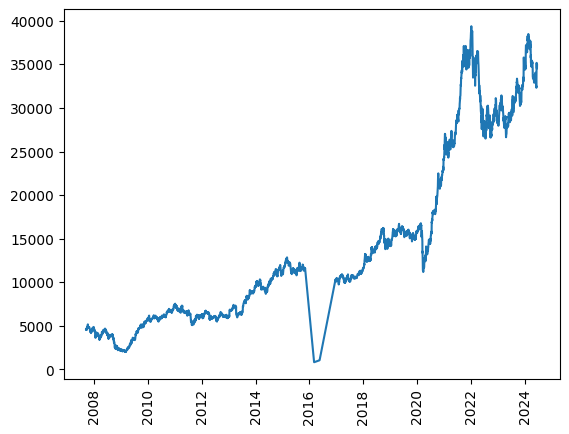

In [ ]:
plt.plot(data)
plt.xticks(rotation=90)
plt.show()

In [ ]:
timestep=50
test_size=1500
x_train,x_val,x_test,y_train,y_val,y_test=get_train_val_test_data(data,timestep,test_size)

In [ ]:
def model_builder(hp):
    model = Sequential()

    hp_units=hp.Int("units",min_value=20,max_value=300,step=10)
    hp_dropout_1 = hp.Float("dropout_1", min_value=0.1, max_value=0.5, step=0.1)
    hp_dropout_2 = hp.Float("dropout_2", min_value=0.1, max_value=0.5, step=0.1)
    hp_dropout_3 = hp.Float("dropout_3", min_value=0.1, max_value=0.5, step=0.1)

    model.add(LSTM(hp_units, return_sequences=True,input_shape=(50,1)))
    model.add(Dropout(hp_dropout_1)) #dropout to avoid overfitting
    model.add(LSTM(hp_units,return_sequences=True))
    model.add(Dropout(hp_dropout_2)) #dropout to avoid overfitting
    model.add(LSTM(hp_units))
    model.add(Dropout(hp_dropout_3)) #dropout to avoid overfitting
    model.add(Dense(1))
    # Tune the optimizer choice
    hp_optimizer = hp.Choice("optimizer", values=["adam", "rmsprop", "sgd", "nadam", "adagrad", "adadelta"])
    model.compile(loss='mean_squared_error', optimizer=hp_optimizer,)
    return model

In [ ]:
!rm -rf "/content/my_dir"

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='loss',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='lstm_tunning')

In [ ]:
class CustomStopper(Callback):
    def __init__(self, max_trials, patience):
        super(CustomStopper, self).__init__()
        self.max_trials = max_trials
        self.patience = patience
        self.trial_count = 0
        self.best_loss = float('inf')
        self.wait = 0

    def on_train_end(self,a):
        self.trial_count += 1
        # Stop training if the maximum number of trials is exceeded
        if self.trial_count > self.max_trials:
            self.model.stop_training = True
            print(f"Stopped at {self.trial_count} trials due to reaching the maximum number of trials.")

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1
            # Stop training if validation loss does not improve for `patience` trials
            if self.wait >= self.patience:
                self.model.stop_training = True
                print(f"Stopped at {self.trial_count} trials due to no improvement in loss for {self.patience} trials.")


In [ ]:
max_trials = 100
patience = 5
custom_stopper = CustomStopper(max_trials=max_trials, patience=patience)

tuner.search(x_train, y_train, epochs=50, validation_data=(x_val,y_val), callbacks=[custom_stopper])

Trial 90 Complete [00h 00m 41s]
loss: 0.00038770679384469986

Best loss So Far: 0.00021448054758366197
Total elapsed time: 00h 25m 29s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.values

{'units': 260,
 'dropout_1': 0.5,
 'dropout_2': 0.5,
 'dropout_3': 0.1,
 'optimizer': 'nadam',
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0067'}

In [ ]:

early_stopping = EarlyStopping(
    monitor='loss',       # Monitor the training loss
    min_delta=0.001,      # Minimum change to qualify as an improvement
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
best_model = tuner.hypermodel.build(best_hps)

best_model.fit(x_train, y_train, epochs=50,verbose=1,callbacks=[early_stopping],validation_data=(x_val,y_val))

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0127 - val_loss: 1.1113e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.5362e-04 - val_loss: 8.3003e-05
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.4324e-04 - val_loss: 7.9976e-05
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0611e-04 - val_loss: 5.4438e-05
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.4368e-04 - val_loss: 2.1506e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.8311e-04 - val_loss: 4.3937e-05
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.3964e-04 - val_loss: 3.9398e-05
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
prediction_train=best_model.predict(x_train)
prediction_val=best_model.predict(x_val)
prediction_test=best_model.predict(x_test)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
inversed_y_test=scaler.inverse_transform(y_test)
inversed_y_train=scaler.inverse_transform(y_train)
inversed_y_val=scaler.inverse_transform(y_val)

In [ ]:
inversed_train_prediction=scaler.inverse_transform(prediction_train)
inversed_val_prediction=scaler.inverse_transform(prediction_val)
inversed_test_prediction=scaler.inverse_transform(prediction_test)

In [ ]:
#rmse
training_rmse=np.sqrt(mean_squared_error(inversed_train_prediction,inversed_y_train))
validation_rmse=np.sqrt(mean_squared_error(inversed_val_prediction,inversed_y_val))
test_rmse=np.sqrt(mean_squared_error(inversed_test_prediction,inversed_y_test))

In [ ]:
print(f"Training RMSE: {training_rmse}")
print(f"Validation RMSE: {validation_rmse}")
print(f"Testing RMSE: {test_rmse}")

Training RMSE: 605.9450622336594
Validation RMSE: 351.1297684581999
Testing RMSE: 1092.711903880523


In [ ]:
#mean absolute error(mae)
training_mae=mean_absolute_error(inversed_train_prediction,inversed_y_train)
validation_mae=mean_absolute_error(inversed_val_prediction,inversed_y_val)
test_mae=mean_absolute_error(inversed_test_prediction,inversed_y_test)

In [ ]:
print(f"Training Mean Absolute errorE: {training_mae}")
print(f"Validation Mean Absolute error: {validation_mae}")
print(f"Testing Mean Absolute error: {test_mae}")

Training Mean Absolute errorE: 287.65246636771303
Validation Mean Absolute error: 273.63034736517955
Testing Mean Absolute error: 784.973431640625


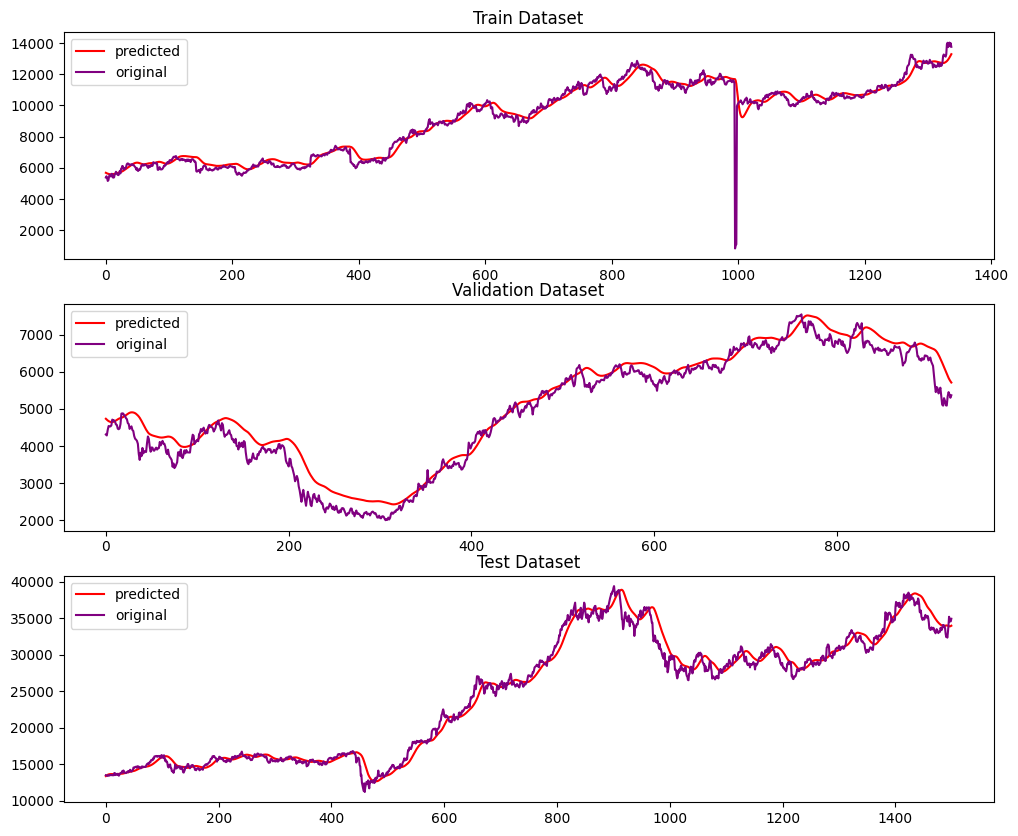

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
plt.plot(inversed_train_prediction,label="predicted",color="red")
plt.plot(inversed_y_train,label="original",color="purple")
plt.title("Train Dataset")
plt.legend()

plt.subplot(3,1,2)
plt.plot(inversed_val_prediction,label="predicted",color="red")
plt.plot(inversed_y_val,label="original",color="purple")
plt.title("Validation Dataset")
plt.legend()

plt.subplot(3,1,3)
plt.plot(inversed_test_prediction,label="predicted",color="red")
plt.plot(inversed_y_test,label="original",color="purple")
plt.title("Test Dataset")
plt.legend()
